In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

In [47]:
image = mpimg.imread("images/test.jpg")

img type:  <class 'numpy.ndarray'> 
 img size:  (540, 960, 3)


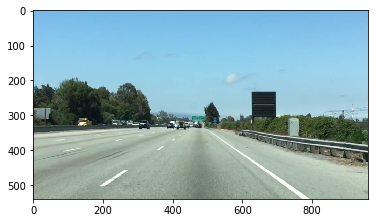

In [48]:
plt.imshow(image)
print("img type: ",type(image), "\n img size: ",image.shape)

In [176]:
ysize = image.shape[0]
xsize = image.shape[1]

In [228]:
color_select = np.copy(image)
#if there is alpha channel this is to skip it.
color_select = color_select[:,:,:3]

In [214]:
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

In [226]:
thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2]) 

In [227]:
color_select[thresholds] = [0,0,0]

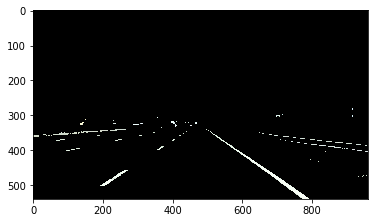

In [217]:
plt.imshow(color_select)
plt.show()

In [218]:
color_select[thresholds].shape

(512594, 3)

In [219]:
color_select[thresholds] 

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

In [220]:
mpimg.imsave("images/test-after.png", color_select)

In [229]:
left_bottom = [0, 539]
right_bottom = [900, 539]
apex = [455, 320]

In [230]:
# Fit lines (y=Ax+B) to identify the  3 sided region of interest
# np.polyfit() returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)


In [231]:
# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

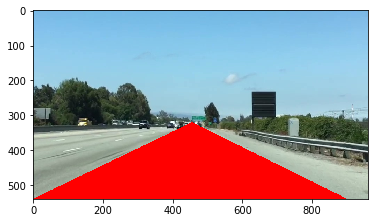

In [232]:
# Color pixels red which are inside the region of interest
color_select[region_thresholds] = [255, 0, 0]

# Display the image
plt.imshow(color_select)


## Canny Edge detection on image:

To find lane lines we first have to detect the sudden changes in pixel values, this sudden changes are mostly on the edges of objects in images due to illumination. So, first lets convert our image into grayscale and then run canny edge detection on them.

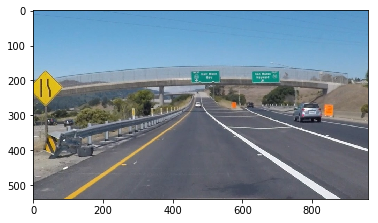

In [13]:
another_image = mpimg.imread("images\exit-ramp.jpg")
plt.imshow(another_image)

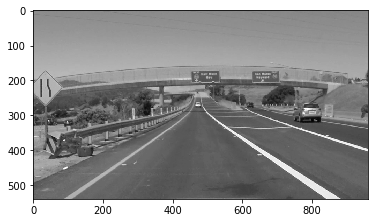

In [17]:
gray = cv2.cvtColor(another_image,cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

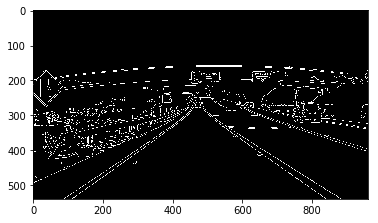

In [45]:
#creteria of egde linking(The smallest value between low_threshold and high_threshold is used for edge linking).
low_threshold = 50
high_threshold = 150

#A larger kernel_size implies averaging, or smoothing, over a larger area.
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')
plt.imsave("images/canny.jpg", edges)

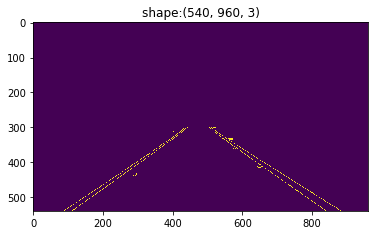

In [117]:
# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices  = np.array([[(50,imshape[0]),(420, 300), (520,300), (900, imshape[0])]], dtype = np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges,mask)
mpimg.imsave("images/area_of_interest.jpg", masked_edges)
plt.title("shape:"+str(imshape))
plt.imshow(masked_edges)

## Hough transform to find lane lines
 Hough transform is the way to represent points, lines, or any shapes from image space(x,y) to Hough space($\rho,\theta$).
 
 where $\rho$ is the perpendicular distance of a line from origin and $\theta$ is the distance angle w.r.t horizontal axis.
 
 to accomplish the task of finding lane lines, we need to specify some parameters to say what kind of lines we want to detect (i.e., long lines, short lines, bendy lines, dashed lines, etc.).

To do this, we'll be using an OpenCV function called HoughLinesP that takes several parameters. Let's code it up and find the lane lines in the image we detected edges in with the Canny function (for a look at coding up a Hough Transform from scratch, check [this](https://alyssaq.github.io/2014/understanding-hough-transform/) out.)

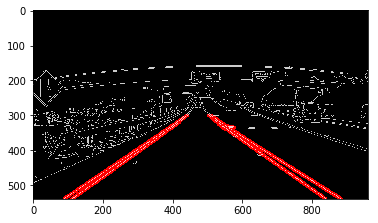

In [123]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho =2
theta = np.pi/180
threshold = 17
min_line_length = 40
max_line_gap = 20

line_image = np.copy(image)*0 #creating a blank to draw lines on

# Run Hough on edge detected image
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

#lines will contain list of all lines coordinates[(x1,y1)(x2,y2)]
# Iterate over the output "lines" and draw lines on the blank
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image, (x1,y1), (x2,y2), (255.,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges))

# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(combo)
mpimg.imsave("images/hough_transformed_line_image.jpg", combo)

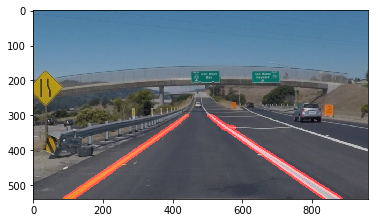

In [126]:
colored_combo = cv2.addWeighted(another_image, 0.8, line_image, 1, 0) 
plt.imshow(colored_combo)
mpimg.imsave("images/hough_transformed_on_colored_image.jpg", colored_combo)